In [1]:
import multiprocessing
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader
import torch
torch.manual_seed(17)

from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

class FetchDataset:

    def __init__(self, dataset="CIFAR10", batch_size=64):
        print("Initializing fetching %s dataset using torchvision"%(dataset))
        self.datasetObject = torchvision.datasets.__dict__.get(dataset, None)
        if self.datasetObject == None:
            raise Exception("Dataset %s not available in torchvision."%(dataset))
        self.batch_size = batch_size
        self.transformers_training = []
        self.transformers_testing = []
        self.workersAvailable = min(multiprocessing.cpu_count(), 14)
      
    def dataAugmentation(self, size=32, padding=3):
        self.transformers_training.append(transforms.RandomHorizontalFlip())
        self.transformers_training.append(transforms.RandomCrop(size=size, padding=padding))
        self.transformers_training.append(transforms.functional.equalize)
        self.transformers_testing.append(transforms.functional.equalize)

    def __addToTensor(self):
        self.transformers_training.append(transforms.ToTensor())
        self.transformers_testing.append(transforms.ToTensor())

    def addNormalizer(self):
        self.__addToTensor()
        dataset_training = self.datasetObject(root="./data", train=True, download=True)
        data_train = dataset_training.data/255.0
        mean = data_train.mean(axis=(0, 1, 2))
        std = data_train.std(axis=(0, 1, 2))
        self.transformers_training.append(transforms.Normalize(mean=mean, std=std))
        self.transformers_testing.append(transforms.Normalize(mean=mean, std=std))
        

    def getLoaders(self):
        if len(self.transformers_training) == 0:
            self.__addToTensor()
        dataset_training = self.datasetObject(root="./data", train=True, download=True, transform=transforms.Compose(self.transformers_training))
        dataset_testing = self.datasetObject(root="./data", train=False, download=True, transform=transforms.Compose(self.transformers_testing))
        load_train = DataLoader(dataset_training, batch_size=self.batch_size, shuffle=True, num_workers=self.workersAvailable)
        load_test = DataLoader(dataset_testing, batch_size=self.batch_size, shuffle=False, num_workers=self.workersAvailable)
        return load_train, load_test
    

df = FetchDataset(dataset="CIFAR10", batch_size=128)
df.dataAugmentation(size=32, padding=4)
df.addNormalizer()
trainLoader, testLoader = df.getLoaders()

Initializing fetching CIFAR10 dataset using torchvision


100%|██████████| 170498071/170498071 [00:06<00:00, 28220738.62it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [2]:

import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, kernel_size, skip_kernel, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=kernel_size, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=kernel_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=skip_kernel, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):

    def __init__(self,N:int, B:list, C:list, F:list, K:list, P:int, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = C[0]
        self.block = BasicBlock
        self.N, self.B, self.C, self.F, self.K, self.P= N, B, C, F, K, P
        self.layers = []          # layers container
        self.S = [2] * N          # strides for layers
        self.S[0] = 1

        # Output Liner layer input dimension
        self.outLayerInSize = C[N-1]*(32//(P*2**(N-1)))*(32//(P*2**(N-1)))

        # Print Model Config
        print("\n\nModel Config: "
            "\n-------------------------------------"
            "\nN (# Layers)\t:",self.N,
            "\nB (# Blocks)\t:",self.B,
            "\nC (# Channels)\t:",C,
            "\nF (Conv Kernel)\t:",F,
            "\nK (Skip Kernel)\t:",K,
            "\nP (Pool Kernel)\t:",P,)

        self.conv1 = nn.Conv2d(3, C[0], kernel_size=F[0], stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(C[0])
        for i in range(N): 
            exec("self.layer{} = self._make_layer(self.block, self.C[{}], self.B[{}], self.F[{}], self.K[{}], self.S[{}])"\
                .format(i+1,i,i,i,i,i))
            exec("self.layers.append(self.layer{})".format(i+1))
        self.linear = nn.Linear(self.outLayerInSize, num_classes)
        

    def _make_layer(self, block, planes, num_blocks, kernel_size, skip_kernel, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, kernel_size, skip_kernel, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        for layer in self.layers:
            out = layer(out)
        out = F.avg_pool2d(out, self.P)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def project1_model():

    B=[3,3,2,3]
    C=[64,128,128,256]
    F=[3,3,3,3]
    K=[1,1,1,1]
    P=4
    N=len(B)

    return ResNet(N, B, C, F, K, P)



In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
model = project1_model()
model = model.to(device)



Model Config: 
-------------------------------------
N (# Layers)	: 4 
B (# Blocks)	: [3, 3, 2, 3] 
C (# Channels)	: [64, 128, 128, 256] 
F (Conv Kernel)	: [3, 3, 3, 3] 
K (Skip Kernel)	: [1, 1, 1, 1] 
P (Pool Kernel)	: 4


In [5]:
EPOCHS=300
globalBestAccuracy = 0.0
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

loss_function = torch.nn.CrossEntropyLoss(reduction='sum')
learningRate = 0.01
weightDecay = 0.0001
optimizer = torch.optim.Adagrad(model.parameters(), lr=learningRate, weight_decay=weightDecay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS, eta_min=learningRate/10.0)
print(model.eval())
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Trainable Parameters : %s"%(trainable_parameters))
if trainable_parameters > 5*(10**6):
    raise Exception("Model not under budget!")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [ ]:
def train(model,loader, optimizer):
    model.train()
    optimizer.zero_grad()
    return model, optimizer

def test(model,loader):
    return model.eval() 

def getLoss(loader,model,optimizer):
    running_loss = 0.0
    running_correct = 0
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        loss = loss_function(output, labels)
        predicted_labels = torch.argmax(output, dim=1)
        running_loss += loss.item()
        running_correct += torch.sum(predicted_labels == labels).float().item()
        if phase == "train":
            loss.backward()
            optimizer.step()
    return running_loss,running_correct

for i in tqdm(range(EPOCHS)):
    for phase in ['train', 'test']:
        if phase == "train":
            loader = trainLoader
            model,optimzier= train(model,loader,optimizer)
        else:
            loader = testLoader
            model=test(model,loader)
        running_loss,running_correct = getLoss(loader,model,optimizer)
        epoch_loss = running_loss/len(loader.dataset)
        epoch_acc = running_correct/len(loader.dataset)
        if phase == "train":
            scheduler.step()
            train_loss.append(epoch_loss)
            train_accuracy.append(epoch_acc)
        else:
            test_loss.append(epoch_loss)
            test_accuracy.append(epoch_acc)
            globalBestAccuracy = max(globalBestAccuracy, epoch_acc) 
    print("Training Loss : %s, Testing Loss : %s, Training Accuracy : %s, Testing Accuracy : %s"\
          %(train_loss[-1], test_loss[-1], train_accuracy[-1], test_accuracy[-1]))

  0%|          | 1/300 [00:58<4:52:21, 58.67s/it]

Training Loss : 2.388981614074707, Testing Loss : 2.659237770462036, Training Accuracy : 0.11258, Testing Accuracy : 0.1302


  1%|          | 2/300 [01:49<4:29:16, 54.22s/it]

Training Loss : 2.212431922302246, Testing Loss : 2.1419365310668947, Training Accuracy : 0.15554, Testing Accuracy : 0.1989


  1%|          | 3/300 [02:41<4:21:38, 52.86s/it]

Training Loss : 2.055349197387695, Testing Loss : 2.0132826978683473, Training Accuracy : 0.2055, Testing Accuracy : 0.2302


  1%|▏         | 4/300 [03:31<4:16:15, 51.94s/it]

Training Loss : 1.9734908541870118, Testing Loss : 1.9726553539276124, Training Accuracy : 0.24128, Testing Accuracy : 0.263


  2%|▏         | 5/300 [04:22<4:13:49, 51.63s/it]

Training Loss : 1.9080236404418944, Testing Loss : 1.8963048000335694, Training Accuracy : 0.28132, Testing Accuracy : 0.3057


  2%|▏         | 6/300 [05:12<4:10:14, 51.07s/it]

Training Loss : 1.8334224780273438, Testing Loss : 1.8023167922973633, Training Accuracy : 0.31378, Testing Accuracy : 0.323


  2%|▏         | 7/300 [06:03<4:09:32, 51.10s/it]

Training Loss : 1.745305053100586, Testing Loss : 1.727079423904419, Training Accuracy : 0.35784, Testing Accuracy : 0.377


  3%|▎         | 8/300 [06:54<4:08:19, 51.03s/it]

Training Loss : 1.6456219467163087, Testing Loss : 1.6748994562149049, Training Accuracy : 0.40342, Testing Accuracy : 0.3945


  3%|▎         | 9/300 [07:45<4:06:31, 50.83s/it]

Training Loss : 1.5428573306274413, Testing Loss : 1.5789405811309813, Training Accuracy : 0.44348, Testing Accuracy : 0.4428


  3%|▎         | 10/300 [08:35<4:05:46, 50.85s/it]

Training Loss : 1.4494548870849608, Testing Loss : 1.5701306219100952, Training Accuracy : 0.47658, Testing Accuracy : 0.4489


  4%|▎         | 11/300 [09:25<4:03:38, 50.58s/it]

Training Loss : 1.3666699163818359, Testing Loss : 1.4820309703826904, Training Accuracy : 0.50924, Testing Accuracy : 0.4811


  4%|▍         | 12/300 [10:16<4:03:15, 50.68s/it]

Training Loss : 1.3074955409240723, Testing Loss : 1.3763873640060424, Training Accuracy : 0.53168, Testing Accuracy : 0.52


  4%|▍         | 13/300 [11:08<4:04:13, 51.06s/it]

Training Loss : 1.2335591638183594, Testing Loss : 1.3430294883728027, Training Accuracy : 0.5599, Testing Accuracy : 0.5311


  5%|▍         | 14/300 [11:59<4:02:30, 50.88s/it]

Training Loss : 1.16911349899292, Testing Loss : 1.2513691356658936, Training Accuracy : 0.5829, Testing Accuracy : 0.5695


  5%|▌         | 15/300 [12:50<4:02:53, 51.13s/it]

Training Loss : 1.1288840731811522, Testing Loss : 1.1872649477005004, Training Accuracy : 0.60048, Testing Accuracy : 0.5809


  5%|▌         | 16/300 [13:41<4:01:37, 51.05s/it]

Training Loss : 1.0858180690002441, Testing Loss : 1.1815368228912353, Training Accuracy : 0.61492, Testing Accuracy : 0.5937


  6%|▌         | 17/300 [14:33<4:01:29, 51.20s/it]

Training Loss : 1.0407546658325195, Testing Loss : 1.0999248971939086, Training Accuracy : 0.63108, Testing Accuracy : 0.6136


  6%|▌         | 18/300 [15:23<3:59:47, 51.02s/it]

Training Loss : 1.0107395431518555, Testing Loss : 1.0658110706329347, Training Accuracy : 0.6437, Testing Accuracy : 0.6285


  6%|▋         | 19/300 [16:15<3:59:07, 51.06s/it]

Training Loss : 0.9793333491516113, Testing Loss : 1.0722892993927002, Training Accuracy : 0.65348, Testing Accuracy : 0.6345


  7%|▋         | 20/300 [17:06<3:58:28, 51.10s/it]

Training Loss : 0.9351658134460449, Testing Loss : 0.9958641260147095, Training Accuracy : 0.66894, Testing Accuracy : 0.6502


  7%|▋         | 21/300 [17:56<3:56:42, 50.91s/it]

Training Loss : 0.9047154899597168, Testing Loss : 0.9942147081375122, Training Accuracy : 0.68094, Testing Accuracy : 0.6548


  7%|▋         | 22/300 [18:47<3:55:11, 50.76s/it]

Training Loss : 0.8783432387542724, Testing Loss : 0.9321529233932495, Training Accuracy : 0.68904, Testing Accuracy : 0.6772


  8%|▊         | 23/300 [19:37<3:53:51, 50.66s/it]

Training Loss : 0.8472818908691406, Testing Loss : 0.8962799120903016, Training Accuracy : 0.70086, Testing Accuracy : 0.6893


  8%|▊         | 24/300 [20:28<3:53:19, 50.72s/it]

Training Loss : 0.8179936173248291, Testing Loss : 0.8944626900672913, Training Accuracy : 0.71274, Testing Accuracy : 0.6934


  8%|▊         | 25/300 [21:18<3:51:49, 50.58s/it]

Training Loss : 0.8076594950866699, Testing Loss : 0.852263569355011, Training Accuracy : 0.71488, Testing Accuracy : 0.7091


  9%|▊         | 26/300 [22:09<3:51:49, 50.76s/it]

Training Loss : 0.7725940003967285, Testing Loss : 0.8311148212432862, Training Accuracy : 0.72924, Testing Accuracy : 0.7135


  9%|▉         | 27/300 [23:01<3:51:55, 50.97s/it]

Training Loss : 0.7570569386291504, Testing Loss : 0.8375407131195068, Training Accuracy : 0.73328, Testing Accuracy : 0.711


  9%|▉         | 28/300 [23:51<3:50:36, 50.87s/it]

Training Loss : 0.7149375775146485, Testing Loss : 0.7880663021087646, Training Accuracy : 0.7498, Testing Accuracy : 0.7278


 10%|▉         | 29/300 [24:43<3:50:16, 50.98s/it]

Training Loss : 0.6961216296386719, Testing Loss : 0.7814806345939637, Training Accuracy : 0.75778, Testing Accuracy : 0.7301


 10%|█         | 30/300 [25:34<3:49:23, 50.98s/it]

Training Loss : 0.6739821798706055, Testing Loss : 0.7475904782295227, Training Accuracy : 0.76388, Testing Accuracy : 0.7429


 10%|█         | 31/300 [26:25<3:49:25, 51.17s/it]

Training Loss : 0.6507257785797119, Testing Loss : 0.7585425639152527, Training Accuracy : 0.77142, Testing Accuracy : 0.7382


 11%|█         | 32/300 [27:18<3:49:56, 51.48s/it]

Training Loss : 0.6303706154632568, Testing Loss : 0.7596919018745423, Training Accuracy : 0.77816, Testing Accuracy : 0.7413


 11%|█         | 33/300 [28:08<3:48:23, 51.32s/it]

Training Loss : 0.6299243891143799, Testing Loss : 0.7495562395095825, Training Accuracy : 0.77826, Testing Accuracy : 0.7443


 11%|█▏        | 34/300 [29:00<3:47:46, 51.38s/it]

Training Loss : 0.6051960601806641, Testing Loss : 0.7327725450515747, Training Accuracy : 0.78834, Testing Accuracy : 0.748


 12%|█▏        | 35/300 [29:51<3:45:55, 51.15s/it]

Training Loss : 0.5971179230499267, Testing Loss : 0.7320741806030273, Training Accuracy : 0.79168, Testing Accuracy : 0.7507


 12%|█▏        | 36/300 [30:42<3:45:19, 51.21s/it]

Training Loss : 0.5709130388641357, Testing Loss : 0.6680518959045411, Training Accuracy : 0.79968, Testing Accuracy : 0.7747


 12%|█▏        | 37/300 [31:33<3:43:57, 51.09s/it]

Training Loss : 0.5549638961791992, Testing Loss : 0.7150229012489319, Training Accuracy : 0.80496, Testing Accuracy : 0.76


 13%|█▎        | 38/300 [32:24<3:43:34, 51.20s/it]

Training Loss : 0.5335455158233643, Testing Loss : 0.6591824031829834, Training Accuracy : 0.8142, Testing Accuracy : 0.7787


 13%|█▎        | 39/300 [33:16<3:43:11, 51.31s/it]

Training Loss : 0.5191296639251709, Testing Loss : 0.6685770466804505, Training Accuracy : 0.81874, Testing Accuracy : 0.7699


 13%|█▎        | 40/300 [34:07<3:42:11, 51.27s/it]

Training Loss : 0.5144849276733399, Testing Loss : 0.6512754218101502, Training Accuracy : 0.8215, Testing Accuracy : 0.7803


 14%|█▎        | 41/300 [34:58<3:41:33, 51.33s/it]

Training Loss : 0.5013460508728027, Testing Loss : 0.6828714179992675, Training Accuracy : 0.82506, Testing Accuracy : 0.774


 14%|█▍        | 42/300 [35:49<3:40:15, 51.22s/it]

Training Loss : 0.4912989080047607, Testing Loss : 0.6463525983810425, Training Accuracy : 0.82728, Testing Accuracy : 0.7851


 14%|█▍        | 43/300 [36:41<3:40:17, 51.43s/it]

Training Loss : 0.4870649815368652, Testing Loss : 0.6773190017223358, Training Accuracy : 0.8295, Testing Accuracy : 0.7718


 15%|█▍        | 44/300 [37:32<3:38:53, 51.30s/it]

Training Loss : 0.4728953247070313, Testing Loss : 0.6571087141036988, Training Accuracy : 0.83588, Testing Accuracy : 0.7847


 15%|█▌        | 45/300 [38:23<3:37:26, 51.16s/it]

Training Loss : 0.46789550262451174, Testing Loss : 0.6399205213546753, Training Accuracy : 0.83656, Testing Accuracy : 0.7903


 15%|█▌        | 46/300 [39:15<3:36:53, 51.24s/it]

Training Loss : 0.44630194766998293, Testing Loss : 0.6033139620780945, Training Accuracy : 0.84342, Testing Accuracy : 0.7995


 16%|█▌        | 47/300 [40:05<3:35:01, 51.00s/it]

Training Loss : 0.43675074806213376, Testing Loss : 0.6152508665084839, Training Accuracy : 0.847, Testing Accuracy : 0.7976


 16%|█▌        | 48/300 [40:56<3:34:33, 51.09s/it]

Training Loss : 0.42447171195983885, Testing Loss : 0.668424377155304, Training Accuracy : 0.85282, Testing Accuracy : 0.7842


 16%|█▋        | 49/300 [41:47<3:33:09, 50.96s/it]

Training Loss : 0.4293404452896118, Testing Loss : 0.6141692659378052, Training Accuracy : 0.84882, Testing Accuracy : 0.7971


 17%|█▋        | 50/300 [42:38<3:32:37, 51.03s/it]

Training Loss : 0.41274105487823487, Testing Loss : 0.6097884263038635, Training Accuracy : 0.85552, Testing Accuracy : 0.8086


 17%|█▋        | 51/300 [43:30<3:32:13, 51.14s/it]

Training Loss : 0.3926988080596924, Testing Loss : 0.6429955855369568, Training Accuracy : 0.86104, Testing Accuracy : 0.7929


 17%|█▋        | 52/300 [44:20<3:30:53, 51.02s/it]

Training Loss : 0.38801250492095946, Testing Loss : 0.6094447632789611, Training Accuracy : 0.86346, Testing Accuracy : 0.8072


 18%|█▊        | 53/300 [45:12<3:30:28, 51.13s/it]

Training Loss : 0.38211173225402834, Testing Loss : 0.615358328962326, Training Accuracy : 0.86704, Testing Accuracy : 0.8009


 18%|█▊        | 54/300 [46:03<3:29:34, 51.12s/it]

Training Loss : 0.370132198677063, Testing Loss : 0.6030214798927307, Training Accuracy : 0.87112, Testing Accuracy : 0.8061


 18%|█▊        | 55/300 [46:55<3:29:36, 51.33s/it]

Training Loss : 0.3619694297027588, Testing Loss : 0.6420905895233154, Training Accuracy : 0.874, Testing Accuracy : 0.7968


 19%|█▊        | 56/300 [47:46<3:28:23, 51.24s/it]

Training Loss : 0.3626382769393921, Testing Loss : 0.6160215332984924, Training Accuracy : 0.87196, Testing Accuracy : 0.8024


 19%|█▉        | 57/300 [48:37<3:27:56, 51.34s/it]

Training Loss : 0.35611628326416017, Testing Loss : 0.6329483446121216, Training Accuracy : 0.87494, Testing Accuracy : 0.8012


 19%|█▉        | 58/300 [49:29<3:27:13, 51.38s/it]

Training Loss : 0.347316085395813, Testing Loss : 0.5712486513614654, Training Accuracy : 0.87808, Testing Accuracy : 0.8113


 20%|█▉        | 59/300 [50:20<3:25:49, 51.24s/it]

Training Loss : 0.33826490398406983, Testing Loss : 0.6065148161411286, Training Accuracy : 0.88142, Testing Accuracy : 0.8095


 20%|██        | 60/300 [51:11<3:25:20, 51.34s/it]

Training Loss : 0.32356049045562746, Testing Loss : 0.6004112521648407, Training Accuracy : 0.8869, Testing Accuracy : 0.8089


 20%|██        | 61/300 [52:02<3:23:57, 51.20s/it]

Training Loss : 0.33501253551483157, Testing Loss : 0.6018850486278534, Training Accuracy : 0.8819, Testing Accuracy : 0.8085


 21%|██        | 62/300 [52:54<3:23:36, 51.33s/it]

Training Loss : 0.31601593742370604, Testing Loss : 0.5874327317714692, Training Accuracy : 0.89008, Testing Accuracy : 0.8143


 21%|██        | 63/300 [53:44<3:22:08, 51.17s/it]

Training Loss : 0.3067700411224365, Testing Loss : 0.5769439571380616, Training Accuracy : 0.89122, Testing Accuracy : 0.8206


 21%|██▏       | 64/300 [54:36<3:21:28, 51.22s/it]

Training Loss : 0.3001600898361206, Testing Loss : 0.6094839514732361, Training Accuracy : 0.8946, Testing Accuracy : 0.8073


 22%|██▏       | 65/300 [55:27<3:20:17, 51.14s/it]

Training Loss : 0.2976930934906006, Testing Loss : 0.6080030517101288, Training Accuracy : 0.89392, Testing Accuracy : 0.8101


 22%|██▏       | 66/300 [56:17<3:17:52, 50.74s/it]

Training Loss : 0.2933699101638794, Testing Loss : 0.5952992756843567, Training Accuracy : 0.8972, Testing Accuracy : 0.8126


 22%|██▏       | 67/300 [57:07<3:17:14, 50.79s/it]

Training Loss : 0.2826612252807617, Testing Loss : 0.6267939908027649, Training Accuracy : 0.89942, Testing Accuracy : 0.8091


 23%|██▎       | 68/300 [57:58<3:15:40, 50.61s/it]

Training Loss : 0.2791492885971069, Testing Loss : 0.5924207936286926, Training Accuracy : 0.90056, Testing Accuracy : 0.8196


 23%|██▎       | 69/300 [58:49<3:15:34, 50.80s/it]

Training Loss : 0.27477678453445437, Testing Loss : 0.6196199851036072, Training Accuracy : 0.90382, Testing Accuracy : 0.8148


 23%|██▎       | 70/300 [59:39<3:14:15, 50.67s/it]

Training Loss : 0.2638882765769959, Testing Loss : 0.6141593057632446, Training Accuracy : 0.9064, Testing Accuracy : 0.817


 24%|██▎       | 71/300 [1:00:30<3:13:38, 50.74s/it]

Training Loss : 0.2619479797744751, Testing Loss : 0.5780829978466034, Training Accuracy : 0.90792, Testing Accuracy : 0.8234


 24%|██▍       | 72/300 [1:01:21<3:12:48, 50.74s/it]

Training Loss : 0.2444799602508545, Testing Loss : 0.5946215088844299, Training Accuracy : 0.9124, Testing Accuracy : 0.8214


 24%|██▍       | 73/300 [1:02:11<3:11:20, 50.58s/it]

Training Loss : 0.24442973337173463, Testing Loss : 0.5741839630126954, Training Accuracy : 0.9148, Testing Accuracy : 0.8304


 25%|██▍       | 74/300 [1:03:03<3:11:38, 50.88s/it]

Training Loss : 0.24396089206695556, Testing Loss : 0.5908377640724182, Training Accuracy : 0.91262, Testing Accuracy : 0.8251


 25%|██▌       | 75/300 [1:03:53<3:10:30, 50.80s/it]

Training Loss : 0.24433792867660523, Testing Loss : 0.5945894767284393, Training Accuracy : 0.91436, Testing Accuracy : 0.8241


 25%|██▌       | 76/300 [1:04:45<3:10:19, 50.98s/it]

Training Loss : 0.23030189344406127, Testing Loss : 0.619869571685791, Training Accuracy : 0.91864, Testing Accuracy : 0.8165


 26%|██▌       | 77/300 [1:05:35<3:09:06, 50.88s/it]

Training Loss : 0.22860091369628907, Testing Loss : 0.5870883626937866, Training Accuracy : 0.91922, Testing Accuracy : 0.8318


 26%|██▌       | 78/300 [1:06:27<3:08:57, 51.07s/it]

Training Loss : 0.21679716243743896, Testing Loss : 0.6265235948562622, Training Accuracy : 0.92382, Testing Accuracy : 0.8212


 26%|██▋       | 79/300 [1:07:19<3:09:05, 51.34s/it]

Training Loss : 0.22150268507003784, Testing Loss : 0.60475131483078, Training Accuracy : 0.91978, Testing Accuracy : 0.829


 27%|██▋       | 80/300 [1:08:09<3:07:17, 51.08s/it]

Training Loss : 0.21429609577178954, Testing Loss : 0.6170126800537109, Training Accuracy : 0.9241, Testing Accuracy : 0.826


 27%|██▋       | 81/300 [1:09:01<3:06:58, 51.23s/it]

Training Loss : 0.20774623950004578, Testing Loss : 0.6161043635368347, Training Accuracy : 0.92532, Testing Accuracy : 0.826


 27%|██▋       | 82/300 [1:09:52<3:05:38, 51.09s/it]

Training Loss : 0.2045172501182556, Testing Loss : 0.6286791931152343, Training Accuracy : 0.92796, Testing Accuracy : 0.8272


 28%|██▊       | 83/300 [1:10:43<3:05:24, 51.27s/it]

Training Loss : 0.19931570724487305, Testing Loss : 0.6069419766426086, Training Accuracy : 0.93046, Testing Accuracy : 0.8263


 28%|██▊       | 84/300 [1:11:33<3:03:16, 50.91s/it]

Training Loss : 0.19908504732131957, Testing Loss : 0.6311854812622071, Training Accuracy : 0.92936, Testing Accuracy : 0.8289


 28%|██▊       | 85/300 [1:12:25<3:02:58, 51.06s/it]

Training Loss : 0.1924687378501892, Testing Loss : 0.6288191455841065, Training Accuracy : 0.93186, Testing Accuracy : 0.8269


 29%|██▊       | 86/300 [1:13:17<3:03:32, 51.46s/it]

Training Loss : 0.18532513320922853, Testing Loss : 0.645133787059784, Training Accuracy : 0.93434, Testing Accuracy : 0.8302


 29%|██▉       | 87/300 [1:14:08<3:01:26, 51.11s/it]

Training Loss : 0.17398227102279662, Testing Loss : 0.5997096698760986, Training Accuracy : 0.93882, Testing Accuracy : 0.8318


 29%|██▉       | 88/300 [1:14:59<3:00:34, 51.10s/it]

Training Loss : 0.1632966119003296, Testing Loss : 0.6364252658843994, Training Accuracy : 0.94286, Testing Accuracy : 0.8338


 30%|██▉       | 89/300 [1:15:48<2:58:25, 50.74s/it]

Training Loss : 0.16779245012283325, Testing Loss : 0.6357652458190918, Training Accuracy : 0.94, Testing Accuracy : 0.8318


 30%|███       | 90/300 [1:16:39<2:57:43, 50.78s/it]

Training Loss : 0.17412550086975098, Testing Loss : 0.6461592594146729, Training Accuracy : 0.93668, Testing Accuracy : 0.8293


 30%|███       | 91/300 [1:17:30<2:56:17, 50.61s/it]

Training Loss : 0.1667742974090576, Testing Loss : 0.6525729932785034, Training Accuracy : 0.9406, Testing Accuracy : 0.8305


 31%|███       | 92/300 [1:18:21<2:55:54, 50.74s/it]

Training Loss : 0.16833459201812745, Testing Loss : 0.6373414348602295, Training Accuracy : 0.94, Testing Accuracy : 0.8351


 31%|███       | 93/300 [1:19:11<2:54:58, 50.72s/it]

Training Loss : 0.16237406249046327, Testing Loss : 0.6415386562347412, Training Accuracy : 0.94232, Testing Accuracy : 0.8348


 31%|███▏      | 94/300 [1:20:02<2:54:37, 50.86s/it]

Training Loss : 0.1589219331073761, Testing Loss : 0.6529093616485596, Training Accuracy : 0.9441, Testing Accuracy : 0.8325


 32%|███▏      | 95/300 [1:20:54<2:54:18, 51.02s/it]

Training Loss : 0.16253665259361266, Testing Loss : 0.6592938249588013, Training Accuracy : 0.94244, Testing Accuracy : 0.8308


 32%|███▏      | 96/300 [1:21:44<2:52:56, 50.87s/it]

Training Loss : 0.1561518745803833, Testing Loss : 0.6605203424453735, Training Accuracy : 0.94446, Testing Accuracy : 0.8298


 32%|███▏      | 97/300 [1:22:35<2:52:20, 50.94s/it]

Training Loss : 0.14909222447395326, Testing Loss : 0.6690491393089294, Training Accuracy : 0.94674, Testing Accuracy : 0.829


 33%|███▎      | 98/300 [1:23:26<2:51:24, 50.91s/it]

Training Loss : 0.14076568179130555, Testing Loss : 0.6612570659637451, Training Accuracy : 0.94974, Testing Accuracy : 0.8305


 33%|███▎      | 99/300 [1:24:18<2:51:39, 51.24s/it]

Training Loss : 0.13713046082019806, Testing Loss : 0.6843008611679077, Training Accuracy : 0.95068, Testing Accuracy : 0.8304


 33%|███▎      | 100/300 [1:25:10<2:50:55, 51.28s/it]

Training Loss : 0.13868570837020874, Testing Loss : 0.6660402249336242, Training Accuracy : 0.94992, Testing Accuracy : 0.8358


 34%|███▎      | 101/300 [1:26:02<2:50:43, 51.48s/it]

Training Loss : 0.13311797801971437, Testing Loss : 0.6657753160476685, Training Accuracy : 0.953, Testing Accuracy : 0.8342


 34%|███▍      | 102/300 [1:26:53<2:49:54, 51.49s/it]

Training Loss : 0.1278980042219162, Testing Loss : 0.6492451958656311, Training Accuracy : 0.95446, Testing Accuracy : 0.8365


 34%|███▍      | 103/300 [1:27:44<2:48:36, 51.35s/it]

Training Loss : 0.12677473126411437, Testing Loss : 0.6847084832191467, Training Accuracy : 0.95506, Testing Accuracy : 0.8348


 35%|███▍      | 104/300 [1:28:36<2:48:01, 51.44s/it]

Training Loss : 0.12761578248977662, Testing Loss : 0.6707059787750245, Training Accuracy : 0.95302, Testing Accuracy : 0.834


 35%|███▌      | 105/300 [1:29:27<2:46:43, 51.30s/it]

Training Loss : 0.1210781758594513, Testing Loss : 0.6613248781204224, Training Accuracy : 0.95688, Testing Accuracy : 0.8342


 35%|███▌      | 106/300 [1:30:18<2:46:07, 51.38s/it]

Training Loss : 0.1177213895702362, Testing Loss : 0.6673806804656982, Training Accuracy : 0.95858, Testing Accuracy : 0.8376


 36%|███▌      | 107/300 [1:31:09<2:44:42, 51.20s/it]

Training Loss : 0.11095952048301697, Testing Loss : 0.6808846313476562, Training Accuracy : 0.96068, Testing Accuracy : 0.8389


 36%|███▌      | 108/300 [1:32:01<2:44:19, 51.35s/it]

Training Loss : 0.11336305850982666, Testing Loss : 0.6761161693572998, Training Accuracy : 0.95864, Testing Accuracy : 0.8387


 36%|███▋      | 109/300 [1:32:53<2:44:13, 51.59s/it]

Training Loss : 0.114258802652359, Testing Loss : 0.6597326679229736, Training Accuracy : 0.95874, Testing Accuracy : 0.8387


 37%|███▋      | 110/300 [1:33:44<2:43:06, 51.51s/it]

Training Loss : 0.10633699915409088, Testing Loss : 0.6865220373153686, Training Accuracy : 0.96158, Testing Accuracy : 0.8361


 37%|███▋      | 111/300 [1:34:36<2:42:22, 51.55s/it]

Training Loss : 0.10215302500724792, Testing Loss : 0.676373111152649, Training Accuracy : 0.9644, Testing Accuracy : 0.8396


 37%|███▋      | 112/300 [1:35:27<2:40:41, 51.28s/it]

Training Loss : 0.09654878326892853, Testing Loss : 0.6928431402206421, Training Accuracy : 0.96582, Testing Accuracy : 0.8347


 38%|███▊      | 113/300 [1:36:18<2:40:18, 51.44s/it]

Training Loss : 0.10246536983966828, Testing Loss : 0.6915901414871216, Training Accuracy : 0.96356, Testing Accuracy : 0.8365


 38%|███▊      | 114/300 [1:37:09<2:38:43, 51.20s/it]

Training Loss : 0.10113319043636322, Testing Loss : 0.6918237100601197, Training Accuracy : 0.96406, Testing Accuracy : 0.8389


 38%|███▊      | 115/300 [1:38:00<2:38:00, 51.25s/it]

Training Loss : 0.09395108239650726, Testing Loss : 0.6942163050651551, Training Accuracy : 0.96662, Testing Accuracy : 0.8386


 39%|███▊      | 116/300 [1:38:52<2:37:38, 51.41s/it]

Training Loss : 0.09148586544036866, Testing Loss : 0.6877522054672242, Training Accuracy : 0.96666, Testing Accuracy : 0.8439


 39%|███▉      | 117/300 [1:39:42<2:35:33, 51.00s/it]

Training Loss : 0.09275684565544129, Testing Loss : 0.7221227422714234, Training Accuracy : 0.96682, Testing Accuracy : 0.8371


 39%|███▉      | 118/300 [1:40:33<2:34:43, 51.01s/it]

Training Loss : 0.09014514196872711, Testing Loss : 0.689656526184082, Training Accuracy : 0.96786, Testing Accuracy : 0.8415


 40%|███▉      | 119/300 [1:41:23<2:33:06, 50.75s/it]

Training Loss : 0.08115733937740326, Testing Loss : 0.716530255317688, Training Accuracy : 0.97086, Testing Accuracy : 0.8413


 40%|████      | 120/300 [1:42:14<2:32:19, 50.78s/it]

Training Loss : 0.07939291130542755, Testing Loss : 0.6880287115097046, Training Accuracy : 0.97212, Testing Accuracy : 0.8438


 40%|████      | 121/300 [1:43:04<2:30:48, 50.55s/it]

Training Loss : 0.07739273403644562, Testing Loss : 0.7217275629043579, Training Accuracy : 0.97236, Testing Accuracy : 0.8436


 41%|████      | 122/300 [1:43:55<2:30:17, 50.66s/it]

Training Loss : 0.07552241042613983, Testing Loss : 0.715307901763916, Training Accuracy : 0.97284, Testing Accuracy : 0.8413


 41%|████      | 123/300 [1:44:45<2:29:05, 50.54s/it]

Training Loss : 0.07576076398849488, Testing Loss : 0.7379259834289551, Training Accuracy : 0.97332, Testing Accuracy : 0.8402


 41%|████▏     | 124/300 [1:45:37<2:28:48, 50.73s/it]

Training Loss : 0.07541299030542374, Testing Loss : 0.7288575479507446, Training Accuracy : 0.97406, Testing Accuracy : 0.8418


 42%|████▏     | 125/300 [1:46:28<2:28:13, 50.82s/it]

Training Loss : 0.07509249840259552, Testing Loss : 0.7237686594009399, Training Accuracy : 0.97386, Testing Accuracy : 0.8455


 42%|████▏     | 126/300 [1:47:18<2:27:02, 50.70s/it]

Training Loss : 0.0761260968875885, Testing Loss : 0.7301750118255615, Training Accuracy : 0.97276, Testing Accuracy : 0.8421


 42%|████▏     | 127/300 [1:48:09<2:26:45, 50.90s/it]

Training Loss : 0.0786191806268692, Testing Loss : 0.7712997865676879, Training Accuracy : 0.97296, Testing Accuracy : 0.8404


 43%|████▎     | 128/300 [1:49:00<2:25:39, 50.81s/it]

Training Loss : 0.07542517349481583, Testing Loss : 0.7358490907669067, Training Accuracy : 0.97378, Testing Accuracy : 0.8435


 43%|████▎     | 129/300 [1:49:51<2:25:13, 50.95s/it]

Training Loss : 0.0749290195941925, Testing Loss : 0.7678017229080201, Training Accuracy : 0.97314, Testing Accuracy : 0.8392


 43%|████▎     | 130/300 [1:50:42<2:24:07, 50.87s/it]

Training Loss : 0.07057688527584076, Testing Loss : 0.7431101257324219, Training Accuracy : 0.97578, Testing Accuracy : 0.8459


 44%|████▎     | 131/300 [1:51:33<2:23:30, 50.95s/it]

Training Loss : 0.06747776977062225, Testing Loss : 0.7796620871543885, Training Accuracy : 0.97598, Testing Accuracy : 0.8372


 44%|████▍     | 132/300 [1:52:24<2:22:54, 51.04s/it]

Training Loss : 0.06429501782655717, Testing Loss : 0.7321066556930542, Training Accuracy : 0.97726, Testing Accuracy : 0.8441


 44%|████▍     | 133/300 [1:53:15<2:21:32, 50.86s/it]

Training Loss : 0.058121722717285156, Testing Loss : 0.7643706711769104, Training Accuracy : 0.97966, Testing Accuracy : 0.8418


 45%|████▍     | 134/300 [1:54:06<2:20:58, 50.96s/it]

Training Loss : 0.057603951988220214, Testing Loss : 0.7392899528503418, Training Accuracy : 0.9795, Testing Accuracy : 0.8507


 45%|████▌     | 135/300 [1:54:56<2:19:08, 50.60s/it]

Training Loss : 0.05516699273824692, Testing Loss : 0.7730701209068298, Training Accuracy : 0.98136, Testing Accuracy : 0.8426


 45%|████▌     | 136/300 [1:55:47<2:18:34, 50.70s/it]

Training Loss : 0.057240186340808866, Testing Loss : 0.7854618934631348, Training Accuracy : 0.9798, Testing Accuracy : 0.8426


 46%|████▌     | 137/300 [1:56:37<2:17:06, 50.47s/it]

Training Loss : 0.05876028384208679, Testing Loss : 0.7823755819320679, Training Accuracy : 0.97938, Testing Accuracy : 0.8439


 46%|████▌     | 138/300 [1:57:27<2:16:22, 50.51s/it]

Training Loss : 0.05794756713628769, Testing Loss : 0.7867308298110962, Training Accuracy : 0.97962, Testing Accuracy : 0.8441


 46%|████▋     | 139/300 [1:58:18<2:16:01, 50.69s/it]

Training Loss : 0.05974010593652725, Testing Loss : 0.798840834236145, Training Accuracy : 0.97914, Testing Accuracy : 0.8417


 47%|████▋     | 140/300 [1:59:09<2:14:44, 50.53s/it]

Training Loss : 0.0609993352150917, Testing Loss : 0.7819252729415893, Training Accuracy : 0.97928, Testing Accuracy : 0.8452


 47%|████▋     | 141/300 [1:59:59<2:13:42, 50.46s/it]

Training Loss : 0.05727923675060272, Testing Loss : 0.8044545333862305, Training Accuracy : 0.9789, Testing Accuracy : 0.8419


 47%|████▋     | 142/300 [2:00:49<2:12:40, 50.38s/it]

Training Loss : 0.052275169208049775, Testing Loss : 0.772101996421814, Training Accuracy : 0.9814, Testing Accuracy : 0.8464


 48%|████▊     | 143/300 [2:01:40<2:12:11, 50.52s/it]

Training Loss : 0.04810196406006813, Testing Loss : 0.759254948425293, Training Accuracy : 0.98316, Testing Accuracy : 0.8484


 48%|████▊     | 144/300 [2:02:30<2:11:01, 50.40s/it]

Training Loss : 0.047242190608978274, Testing Loss : 0.7726213119506836, Training Accuracy : 0.98368, Testing Accuracy : 0.845


 48%|████▊     | 145/300 [2:03:21<2:10:32, 50.53s/it]

Training Loss : 0.0441472859120369, Testing Loss : 0.7973066125869751, Training Accuracy : 0.98482, Testing Accuracy : 0.8467


 49%|████▊     | 146/300 [2:04:11<2:09:43, 50.54s/it]

Training Loss : 0.04477585809469223, Testing Loss : 0.7725912099838257, Training Accuracy : 0.98498, Testing Accuracy : 0.8478


 49%|████▉     | 147/300 [2:05:02<2:09:16, 50.70s/it]

Training Loss : 0.04606779140949249, Testing Loss : 0.7999910369873047, Training Accuracy : 0.98368, Testing Accuracy : 0.8438


 49%|████▉     | 148/300 [2:05:54<2:08:43, 50.81s/it]

Training Loss : 0.04080659861326218, Testing Loss : 0.7904334257125855, Training Accuracy : 0.9863, Testing Accuracy : 0.8482


 50%|████▉     | 149/300 [2:06:44<2:07:38, 50.72s/it]

Training Loss : 0.04317579387307167, Testing Loss : 0.7983595752716064, Training Accuracy : 0.98498, Testing Accuracy : 0.8416


 50%|█████     | 150/300 [2:07:35<2:06:55, 50.77s/it]

Training Loss : 0.039038688960075375, Testing Loss : 0.7811599123001098, Training Accuracy : 0.98656, Testing Accuracy : 0.8498


 50%|█████     | 151/300 [2:08:25<2:05:48, 50.66s/it]

Training Loss : 0.038049572464227674, Testing Loss : 0.8087140102386474, Training Accuracy : 0.98642, Testing Accuracy : 0.8444


 51%|█████     | 152/300 [2:09:17<2:05:41, 50.96s/it]

Training Loss : 0.03726710284471512, Testing Loss : 0.7933386374473572, Training Accuracy : 0.98732, Testing Accuracy : 0.8488


 51%|█████     | 153/300 [2:10:08<2:04:51, 50.97s/it]

Training Loss : 0.03945786884784699, Testing Loss : 0.8214187608718873, Training Accuracy : 0.98616, Testing Accuracy : 0.8492


 51%|█████▏    | 154/300 [2:11:00<2:04:37, 51.22s/it]

Training Loss : 0.04040585384249687, Testing Loss : 0.8101735679626465, Training Accuracy : 0.98582, Testing Accuracy : 0.8469


 52%|█████▏    | 155/300 [2:11:51<2:03:43, 51.20s/it]

Training Loss : 0.03820368603050709, Testing Loss : 0.8188704698562622, Training Accuracy : 0.98674, Testing Accuracy : 0.8477


 52%|█████▏    | 156/300 [2:12:41<2:02:24, 51.00s/it]

Training Loss : 0.035308826892375945, Testing Loss : 0.8078414482116699, Training Accuracy : 0.98768, Testing Accuracy : 0.8489


 52%|█████▏    | 157/300 [2:13:33<2:01:41, 51.06s/it]

Training Loss : 0.03193619942009449, Testing Loss : 0.8048193828582764, Training Accuracy : 0.98872, Testing Accuracy : 0.8511


 53%|█████▎    | 158/300 [2:14:23<2:00:19, 50.84s/it]

Training Loss : 0.032351235535740853, Testing Loss : 0.8265341318130494, Training Accuracy : 0.98866, Testing Accuracy : 0.8491


 53%|█████▎    | 159/300 [2:15:15<2:00:13, 51.16s/it]

Training Loss : 0.030300646420121192, Testing Loss : 0.8221224573135376, Training Accuracy : 0.98966, Testing Accuracy : 0.8515


 53%|█████▎    | 160/300 [2:16:04<1:58:11, 50.65s/it]

Training Loss : 0.03188842480421066, Testing Loss : 0.8300546142578125, Training Accuracy : 0.98942, Testing Accuracy : 0.8486


 54%|█████▎    | 161/300 [2:16:55<1:57:34, 50.76s/it]

Training Loss : 0.03297564853608608, Testing Loss : 0.8248109205245971, Training Accuracy : 0.98818, Testing Accuracy : 0.8529


 54%|█████▍    | 162/300 [2:17:47<1:57:01, 50.88s/it]

Training Loss : 0.03137975443303585, Testing Loss : 0.8181804075241089, Training Accuracy : 0.98956, Testing Accuracy : 0.851


 54%|█████▍    | 163/300 [2:18:37<1:55:45, 50.70s/it]

Training Loss : 0.03390514332175255, Testing Loss : 0.8247417585372925, Training Accuracy : 0.98822, Testing Accuracy : 0.8533


 55%|█████▍    | 164/300 [2:19:28<1:55:04, 50.77s/it]

Training Loss : 0.03041057607740164, Testing Loss : 0.8417089748382568, Training Accuracy : 0.98998, Testing Accuracy : 0.8502


 55%|█████▌    | 165/300 [2:20:18<1:53:44, 50.55s/it]

Training Loss : 0.03130663106292486, Testing Loss : 0.817566570854187, Training Accuracy : 0.98874, Testing Accuracy : 0.8525


 55%|█████▌    | 166/300 [2:21:09<1:53:08, 50.66s/it]

Training Loss : 0.030076595074534414, Testing Loss : 0.8476801055908203, Training Accuracy : 0.98978, Testing Accuracy : 0.8499


 56%|█████▌    | 167/300 [2:22:00<1:52:25, 50.72s/it]

Training Loss : 0.0308255841165781, Testing Loss : 0.8565243938446044, Training Accuracy : 0.98926, Testing Accuracy : 0.8501


 56%|█████▌    | 168/300 [2:22:50<1:51:42, 50.77s/it]

Training Loss : 0.03032981772184372, Testing Loss : 0.8375952049255371, Training Accuracy : 0.98966, Testing Accuracy : 0.8529


 56%|█████▋    | 169/300 [2:23:42<1:51:14, 50.95s/it]

Training Loss : 0.03075046690762043, Testing Loss : 0.8523492603302002, Training Accuracy : 0.98924, Testing Accuracy : 0.8466


 57%|█████▋    | 170/300 [2:24:32<1:50:03, 50.80s/it]

Training Loss : 0.028197109272480012, Testing Loss : 0.8572506549835205, Training Accuracy : 0.99, Testing Accuracy : 0.8485


 57%|█████▋    | 171/300 [2:25:24<1:49:50, 51.09s/it]

Training Loss : 0.029100291456878185, Testing Loss : 0.8559737747192383, Training Accuracy : 0.98998, Testing Accuracy : 0.8503


 57%|█████▋    | 172/300 [2:26:15<1:48:44, 50.97s/it]

Training Loss : 0.02909096339046955, Testing Loss : 0.8425636846542358, Training Accuracy : 0.9903, Testing Accuracy : 0.8503


 58%|█████▊    | 173/300 [2:27:06<1:48:08, 51.09s/it]

Training Loss : 0.027441785966753958, Testing Loss : 0.8476246606826783, Training Accuracy : 0.99104, Testing Accuracy : 0.8516


 58%|█████▊    | 174/300 [2:27:58<1:47:38, 51.25s/it]

Training Loss : 0.025260736347436905, Testing Loss : 0.8486410911560058, Training Accuracy : 0.99176, Testing Accuracy : 0.8521


 58%|█████▊    | 175/300 [2:28:48<1:46:12, 50.98s/it]

Training Loss : 0.02525295819759369, Testing Loss : 0.8408314865112305, Training Accuracy : 0.99174, Testing Accuracy : 0.8538


 59%|█████▊    | 176/300 [2:29:39<1:45:24, 51.00s/it]

Training Loss : 0.024660531950891018, Testing Loss : 0.859876533317566, Training Accuracy : 0.9915, Testing Accuracy : 0.8503


 59%|█████▉    | 177/300 [2:30:29<1:43:40, 50.57s/it]

Training Loss : 0.02515393811404705, Testing Loss : 0.8538469436645508, Training Accuracy : 0.99134, Testing Accuracy : 0.8529


 59%|█████▉    | 178/300 [2:31:19<1:42:41, 50.51s/it]

Training Loss : 0.024904218738377094, Testing Loss : 0.8751977741241455, Training Accuracy : 0.99156, Testing Accuracy : 0.8515


 60%|█████▉    | 179/300 [2:32:09<1:41:41, 50.42s/it]

Training Loss : 0.02682977777183056, Testing Loss : 0.8736779859542847, Training Accuracy : 0.9912, Testing Accuracy : 0.8527


 60%|██████    | 180/300 [2:33:00<1:41:04, 50.54s/it]

Training Loss : 0.02283681088924408, Testing Loss : 0.8779887056350708, Training Accuracy : 0.99252, Testing Accuracy : 0.8501


 60%|██████    | 181/300 [2:33:51<1:40:31, 50.69s/it]

Training Loss : 0.023033164103627206, Testing Loss : 0.8741550182342529, Training Accuracy : 0.99256, Testing Accuracy : 0.8499


 61%|██████    | 182/300 [2:34:41<1:39:16, 50.48s/it]

Training Loss : 0.024174918795526027, Testing Loss : 0.8771318338394165, Training Accuracy : 0.99148, Testing Accuracy : 0.8524


 61%|██████    | 183/300 [2:35:33<1:38:58, 50.75s/it]

Training Loss : 0.022523098450005056, Testing Loss : 0.8625905975341797, Training Accuracy : 0.9924, Testing Accuracy : 0.8533


 61%|██████▏   | 184/300 [2:36:23<1:37:51, 50.61s/it]

Training Loss : 0.022418807460069655, Testing Loss : 0.8867452260971069, Training Accuracy : 0.99244, Testing Accuracy : 0.8501


 62%|██████▏   | 185/300 [2:37:18<1:39:23, 51.86s/it]

Training Loss : 0.02076608571588993, Testing Loss : 0.8570481494903565, Training Accuracy : 0.99318, Testing Accuracy : 0.8539


 62%|██████▏   | 186/300 [2:38:09<1:38:07, 51.65s/it]

Training Loss : 0.020767275815308094, Testing Loss : 0.8924260314941406, Training Accuracy : 0.99262, Testing Accuracy : 0.8483


 62%|██████▏   | 187/300 [2:38:59<1:36:29, 51.24s/it]

Training Loss : 0.020765796300172806, Testing Loss : 0.8889637872695922, Training Accuracy : 0.99302, Testing Accuracy : 0.8561


 63%|██████▎   | 188/300 [2:39:50<1:35:28, 51.15s/it]

Training Loss : 0.02025821914330125, Testing Loss : 0.8859417781829834, Training Accuracy : 0.99352, Testing Accuracy : 0.8513


 63%|██████▎   | 189/300 [2:40:40<1:33:50, 50.73s/it]

Training Loss : 0.02008545572578907, Testing Loss : 0.8840208073616028, Training Accuracy : 0.9933, Testing Accuracy : 0.8525


 63%|██████▎   | 190/300 [2:41:31<1:33:10, 50.83s/it]

Training Loss : 0.01991173093467951, Testing Loss : 0.8975914131164551, Training Accuracy : 0.99364, Testing Accuracy : 0.8516


 64%|██████▎   | 191/300 [2:42:21<1:32:07, 50.71s/it]

Training Loss : 0.020261643221974372, Testing Loss : 0.8829423629760742, Training Accuracy : 0.99388, Testing Accuracy : 0.8557


 64%|██████▍   | 192/300 [2:43:12<1:31:35, 50.88s/it]

Training Loss : 0.020113762113153934, Testing Loss : 0.8785186599731445, Training Accuracy : 0.99316, Testing Accuracy : 0.8535


 64%|██████▍   | 193/300 [2:44:03<1:30:46, 50.91s/it]

Training Loss : 0.019390387109220027, Testing Loss : 0.880113069152832, Training Accuracy : 0.9938, Testing Accuracy : 0.8535


 65%|██████▍   | 194/300 [2:44:54<1:29:46, 50.81s/it]

Training Loss : 0.018072067545354367, Testing Loss : 0.8915761989593506, Training Accuracy : 0.99392, Testing Accuracy : 0.8545


 65%|██████▌   | 195/300 [2:45:45<1:29:08, 50.94s/it]

Training Loss : 0.018110413098633288, Testing Loss : 0.8682100234985352, Training Accuracy : 0.99428, Testing Accuracy : 0.8568


 65%|██████▌   | 196/300 [2:46:36<1:28:06, 50.83s/it]

Training Loss : 0.01711904216378927, Testing Loss : 0.8904369743347168, Training Accuracy : 0.9946, Testing Accuracy : 0.8525


 66%|██████▌   | 197/300 [2:47:28<1:27:43, 51.10s/it]

Training Loss : 0.018611725101172923, Testing Loss : 0.8738179090499878, Training Accuracy : 0.994, Testing Accuracy : 0.8573


 66%|██████▌   | 198/300 [2:48:19<1:26:49, 51.07s/it]

Training Loss : 0.016637937467098237, Testing Loss : 0.8752234315872193, Training Accuracy : 0.9943, Testing Accuracy : 0.8564


 66%|██████▋   | 199/300 [2:49:09<1:25:35, 50.84s/it]

Training Loss : 0.015040686433911323, Testing Loss : 0.8722469585418701, Training Accuracy : 0.99518, Testing Accuracy : 0.8589


 67%|██████▋   | 200/300 [2:49:59<1:24:36, 50.77s/it]

Training Loss : 0.01676404000401497, Testing Loss : 0.8829523019790649, Training Accuracy : 0.99456, Testing Accuracy : 0.8556


 67%|██████▋   | 201/300 [2:50:49<1:23:23, 50.54s/it]

Training Loss : 0.016198723319768904, Testing Loss : 0.880979413986206, Training Accuracy : 0.99484, Testing Accuracy : 0.8549


 67%|██████▋   | 202/300 [2:51:39<1:22:13, 50.34s/it]

Training Loss : 0.016357848734557628, Testing Loss : 0.8850710105895996, Training Accuracy : 0.99462, Testing Accuracy : 0.8537


 68%|██████▊   | 203/300 [2:52:29<1:21:04, 50.14s/it]

Training Loss : 0.01447796929091215, Testing Loss : 0.8937238294601441, Training Accuracy : 0.99574, Testing Accuracy : 0.856


 68%|██████▊   | 204/300 [2:53:19<1:20:08, 50.08s/it]

Training Loss : 0.01675404541656375, Testing Loss : 0.8838408559799195, Training Accuracy : 0.9947, Testing Accuracy : 0.8545


 68%|██████▊   | 205/300 [2:54:09<1:19:11, 50.02s/it]

Training Loss : 0.01616661512762308, Testing Loss : 0.9062780054092408, Training Accuracy : 0.99448, Testing Accuracy : 0.8534


 69%|██████▊   | 206/300 [2:54:59<1:18:25, 50.06s/it]

Training Loss : 0.015581955235898495, Testing Loss : 0.9028615447998047, Training Accuracy : 0.99534, Testing Accuracy : 0.8536


 69%|██████▉   | 207/300 [2:55:49<1:17:45, 50.17s/it]

Training Loss : 0.016415441681295634, Testing Loss : 0.9003115661621094, Training Accuracy : 0.99468, Testing Accuracy : 0.8542


 69%|██████▉   | 208/300 [2:56:40<1:17:03, 50.25s/it]

Training Loss : 0.015114322202056647, Testing Loss : 0.8972733764648437, Training Accuracy : 0.99524, Testing Accuracy : 0.8544


 70%|██████▉   | 209/300 [2:57:30<1:16:18, 50.31s/it]

Training Loss : 0.014524497231245041, Testing Loss : 0.8902446525573731, Training Accuracy : 0.99498, Testing Accuracy : 0.8552


 70%|███████   | 210/300 [2:58:21<1:15:31, 50.36s/it]

Training Loss : 0.015401836402118205, Testing Loss : 0.8968761003494262, Training Accuracy : 0.99474, Testing Accuracy : 0.8569


 70%|███████   | 211/300 [2:59:11<1:14:45, 50.40s/it]

Training Loss : 0.013333406520336866, Testing Loss : 0.8906128730773926, Training Accuracy : 0.9958, Testing Accuracy : 0.8563


 71%|███████   | 212/300 [3:00:01<1:13:41, 50.24s/it]

Training Loss : 0.013839757830500603, Testing Loss : 0.8924130876541138, Training Accuracy : 0.99554, Testing Accuracy : 0.8585


 71%|███████   | 213/300 [3:00:51<1:12:37, 50.08s/it]

Training Loss : 0.012869972675293684, Testing Loss : 0.8969893211364746, Training Accuracy : 0.99594, Testing Accuracy : 0.8567


 71%|███████▏  | 214/300 [3:01:41<1:11:46, 50.07s/it]

Training Loss : 0.011906356945335865, Testing Loss : 0.8913933300018311, Training Accuracy : 0.9964, Testing Accuracy : 0.8594


 72%|███████▏  | 215/300 [3:02:31<1:10:47, 49.97s/it]

Training Loss : 0.012469496337473393, Testing Loss : 0.8896896514892578, Training Accuracy : 0.99594, Testing Accuracy : 0.8552


 72%|███████▏  | 216/300 [3:03:21<1:09:54, 49.94s/it]

Training Loss : 0.011636673216223716, Testing Loss : 0.9001321378707886, Training Accuracy : 0.99632, Testing Accuracy : 0.8592


 72%|███████▏  | 217/300 [3:04:11<1:09:07, 49.97s/it]

Training Loss : 0.011207097173780203, Testing Loss : 0.8842233346939087, Training Accuracy : 0.99646, Testing Accuracy : 0.8551


 73%|███████▎  | 218/300 [3:05:01<1:08:26, 50.08s/it]

Training Loss : 0.011055402360111474, Testing Loss : 0.8947841304779053, Training Accuracy : 0.99674, Testing Accuracy : 0.8558


 73%|███████▎  | 219/300 [3:05:51<1:07:46, 50.21s/it]

Training Loss : 0.009634159760847688, Testing Loss : 0.8928461793899536, Training Accuracy : 0.9973, Testing Accuracy : 0.8569


 73%|███████▎  | 220/300 [3:06:42<1:07:04, 50.31s/it]

Training Loss : 0.009804165735393763, Testing Loss : 0.9009537654876709, Training Accuracy : 0.99736, Testing Accuracy : 0.8571


 74%|███████▎  | 221/300 [3:07:33<1:06:24, 50.43s/it]

Training Loss : 0.009305694013535976, Testing Loss : 0.8799414266586304, Training Accuracy : 0.99756, Testing Accuracy : 0.8573


 74%|███████▍  | 222/300 [3:08:24<1:05:45, 50.59s/it]

Training Loss : 0.010821420543044805, Testing Loss : 0.9019451578140258, Training Accuracy : 0.99662, Testing Accuracy : 0.8567


 74%|███████▍  | 223/300 [3:09:14<1:04:56, 50.61s/it]

Training Loss : 0.010279757301583887, Testing Loss : 0.9035356899261474, Training Accuracy : 0.9968, Testing Accuracy : 0.8583


 75%|███████▍  | 224/300 [3:10:04<1:03:55, 50.46s/it]

Training Loss : 0.010627817347943783, Testing Loss : 0.8966915157318115, Training Accuracy : 0.9966, Testing Accuracy : 0.8578


 75%|███████▌  | 225/300 [3:10:54<1:02:44, 50.20s/it]

Training Loss : 0.009732472227588296, Testing Loss : 0.9008595827102661, Training Accuracy : 0.99716, Testing Accuracy : 0.8598


 75%|███████▌  | 226/300 [3:11:44<1:01:44, 50.06s/it]

Training Loss : 0.011025738013461232, Testing Loss : 0.9094002855300903, Training Accuracy : 0.99674, Testing Accuracy : 0.8581


 76%|███████▌  | 227/300 [3:12:34<1:00:56, 50.09s/it]

Training Loss : 0.009891721422746778, Testing Loss : 0.9087912712097168, Training Accuracy : 0.99706, Testing Accuracy : 0.8574


 76%|███████▌  | 228/300 [3:13:24<59:59, 49.99s/it]  

Training Loss : 0.009906748943552375, Testing Loss : 0.9310172071456909, Training Accuracy : 0.99702, Testing Accuracy : 0.8563


 76%|███████▋  | 229/300 [3:14:13<58:59, 49.86s/it]

Training Loss : 0.010029374927133322, Testing Loss : 0.9168732646942138, Training Accuracy : 0.99684, Testing Accuracy : 0.8564


 77%|███████▋  | 230/300 [3:15:03<58:11, 49.87s/it]

Training Loss : 0.009735704822093249, Testing Loss : 0.926829314994812, Training Accuracy : 0.9972, Testing Accuracy : 0.855


 77%|███████▋  | 231/300 [3:15:53<57:29, 49.99s/it]

Training Loss : 0.010323955801576376, Testing Loss : 0.9092667459487915, Training Accuracy : 0.99684, Testing Accuracy : 0.8581


 77%|███████▋  | 232/300 [3:16:44<56:49, 50.14s/it]

Training Loss : 0.00949561282940209, Testing Loss : 0.9251067028045654, Training Accuracy : 0.99736, Testing Accuracy : 0.8565


 78%|███████▊  | 233/300 [3:17:34<56:02, 50.19s/it]

Training Loss : 0.009360466304719449, Testing Loss : 0.9111422117233277, Training Accuracy : 0.99716, Testing Accuracy : 0.8578


 78%|███████▊  | 234/300 [3:18:24<55:11, 50.17s/it]

Training Loss : 0.00963945489540696, Testing Loss : 0.9160741432189942, Training Accuracy : 0.99704, Testing Accuracy : 0.8566


 78%|███████▊  | 235/300 [3:19:15<54:23, 50.21s/it]

Training Loss : 0.009565195651799441, Testing Loss : 0.913344983291626, Training Accuracy : 0.99706, Testing Accuracy : 0.8573


 79%|███████▊  | 236/300 [3:20:05<53:28, 50.13s/it]

Training Loss : 0.009832085754945874, Testing Loss : 0.9239652227401733, Training Accuracy : 0.99694, Testing Accuracy : 0.8582


 79%|███████▉  | 237/300 [3:20:54<52:28, 49.98s/it]

Training Loss : 0.00879582941636443, Testing Loss : 0.9129626457214356, Training Accuracy : 0.9974, Testing Accuracy : 0.857


 79%|███████▉  | 238/300 [3:21:44<51:39, 49.98s/it]

Training Loss : 0.008869230235703289, Testing Loss : 0.9210613033294678, Training Accuracy : 0.9971, Testing Accuracy : 0.8585


 80%|███████▉  | 239/300 [3:22:34<50:46, 49.94s/it]

Training Loss : 0.00874865889698267, Testing Loss : 0.9249499223709107, Training Accuracy : 0.99722, Testing Accuracy : 0.8542


 80%|████████  | 240/300 [3:23:24<49:55, 49.93s/it]

Training Loss : 0.008999459974765778, Testing Loss : 0.9253070413589477, Training Accuracy : 0.9972, Testing Accuracy : 0.8569


 80%|████████  | 241/300 [3:24:14<49:07, 49.96s/it]

Training Loss : 0.009591373311951756, Testing Loss : 0.9236788278579712, Training Accuracy : 0.99712, Testing Accuracy : 0.8555


 81%|████████  | 242/300 [3:25:04<48:24, 50.07s/it]

Training Loss : 0.008510052420943975, Testing Loss : 0.9314093709945679, Training Accuracy : 0.99746, Testing Accuracy : 0.8566


 81%|████████  | 243/300 [3:25:55<47:39, 50.17s/it]

Training Loss : 0.008828709172978998, Testing Loss : 0.9308755393981933, Training Accuracy : 0.99738, Testing Accuracy : 0.8582


 81%|████████▏ | 244/300 [3:26:45<46:57, 50.31s/it]

Training Loss : 0.008336673085615039, Testing Loss : 0.9299931114196778, Training Accuracy : 0.99756, Testing Accuracy : 0.8574


 82%|████████▏ | 245/300 [3:27:36<46:16, 50.48s/it]

Training Loss : 0.00939418252505362, Testing Loss : 0.9237174228668212, Training Accuracy : 0.99688, Testing Accuracy : 0.8545


 82%|████████▏ | 246/300 [3:28:26<45:23, 50.43s/it]

Training Loss : 0.008788601511120797, Testing Loss : 0.931236312675476, Training Accuracy : 0.99752, Testing Accuracy : 0.8563


 82%|████████▏ | 247/300 [3:29:17<44:38, 50.54s/it]

Training Loss : 0.008272192061543464, Testing Loss : 0.9294519172668457, Training Accuracy : 0.99758, Testing Accuracy : 0.8575


 83%|████████▎ | 248/300 [3:30:08<43:48, 50.54s/it]

Training Loss : 0.008053865896239876, Testing Loss : 0.9328056188583373, Training Accuracy : 0.99746, Testing Accuracy : 0.8563


 83%|████████▎ | 249/300 [3:30:57<42:43, 50.27s/it]

Training Loss : 0.00902509807869792, Testing Loss : 0.9351362548828125, Training Accuracy : 0.9972, Testing Accuracy : 0.8573


 83%|████████▎ | 250/300 [3:31:47<41:41, 50.02s/it]

Training Loss : 0.008125683816820384, Testing Loss : 0.9408208400726318, Training Accuracy : 0.99766, Testing Accuracy : 0.8577


 84%|████████▎ | 251/300 [3:32:37<40:48, 49.97s/it]

Training Loss : 0.009015599788054824, Testing Loss : 0.9319133874893188, Training Accuracy : 0.99706, Testing Accuracy : 0.8575


 84%|████████▍ | 252/300 [3:33:26<39:55, 49.91s/it]

Training Loss : 0.00868088983669877, Testing Loss : 0.925238885307312, Training Accuracy : 0.99744, Testing Accuracy : 0.8586


 84%|████████▍ | 253/300 [3:34:16<39:02, 49.84s/it]

Training Loss : 0.008392318808734417, Testing Loss : 0.9333776216506958, Training Accuracy : 0.99752, Testing Accuracy : 0.8589


 85%|████████▍ | 254/300 [3:35:06<38:13, 49.87s/it]

Training Loss : 0.00704302683711052, Testing Loss : 0.928751563835144, Training Accuracy : 0.998, Testing Accuracy : 0.8585


 85%|████████▌ | 255/300 [3:35:56<37:26, 49.91s/it]

Training Loss : 0.007098149619251489, Testing Loss : 0.9308722078323364, Training Accuracy : 0.99792, Testing Accuracy : 0.8593


 85%|████████▌ | 256/300 [3:36:47<36:42, 50.06s/it]

Training Loss : 0.007132038289383053, Testing Loss : 0.9311711549758911, Training Accuracy : 0.99804, Testing Accuracy : 0.8583


 86%|████████▌ | 257/300 [3:37:37<35:59, 50.21s/it]

Training Loss : 0.007478562691360712, Testing Loss : 0.9240003032684326, Training Accuracy : 0.99772, Testing Accuracy : 0.8607


 86%|████████▌ | 258/300 [3:38:28<35:11, 50.28s/it]

Training Loss : 0.007739308661967516, Testing Loss : 0.9277831508636475, Training Accuracy : 0.99776, Testing Accuracy : 0.8575


 86%|████████▋ | 259/300 [3:39:18<34:20, 50.27s/it]

Training Loss : 0.006997349965721369, Testing Loss : 0.930164461517334, Training Accuracy : 0.99792, Testing Accuracy : 0.8582


 87%|████████▋ | 260/300 [3:40:08<33:30, 50.26s/it]

Training Loss : 0.006433843472525478, Testing Loss : 0.9268749704360962, Training Accuracy : 0.99824, Testing Accuracy : 0.8586


 87%|████████▋ | 261/300 [3:40:58<32:40, 50.28s/it]

Training Loss : 0.00731976341329515, Testing Loss : 0.924754288482666, Training Accuracy : 0.99796, Testing Accuracy : 0.8595


 87%|████████▋ | 262/300 [3:41:48<31:43, 50.09s/it]

Training Loss : 0.00627025482725352, Testing Loss : 0.9290967809677124, Training Accuracy : 0.99824, Testing Accuracy : 0.8585


 88%|████████▊ | 263/300 [3:42:38<30:49, 49.99s/it]

Training Loss : 0.006805733018815517, Testing Loss : 0.9347064580917358, Training Accuracy : 0.9981, Testing Accuracy : 0.8587


 88%|████████▊ | 264/300 [3:43:28<30:00, 50.01s/it]

Training Loss : 0.007089292626231909, Testing Loss : 0.9411896284103394, Training Accuracy : 0.9981, Testing Accuracy : 0.8565


 88%|████████▊ | 265/300 [3:44:17<29:06, 49.90s/it]

Training Loss : 0.006547916394025088, Testing Loss : 0.937509210395813, Training Accuracy : 0.99836, Testing Accuracy : 0.858


 89%|████████▊ | 266/300 [3:45:07<28:15, 49.87s/it]

Training Loss : 0.007123002969175577, Testing Loss : 0.9364353580474853, Training Accuracy : 0.99796, Testing Accuracy : 0.8594


 89%|████████▉ | 267/300 [3:45:57<27:23, 49.81s/it]

Training Loss : 0.007243478141650558, Testing Loss : 0.9333919166564941, Training Accuracy : 0.99772, Testing Accuracy : 0.8594


 89%|████████▉ | 268/300 [3:46:47<26:34, 49.82s/it]

Training Loss : 0.00716396487697959, Testing Loss : 0.9429494386672974, Training Accuracy : 0.99768, Testing Accuracy : 0.8585


 90%|████████▉ | 269/300 [3:47:37<25:49, 49.99s/it]

Training Loss : 0.007635551358908415, Testing Loss : 0.9381503585815429, Training Accuracy : 0.99768, Testing Accuracy : 0.8585


 90%|█████████ | 270/300 [3:48:28<25:04, 50.14s/it]

Training Loss : 0.0071545587092638014, Testing Loss : 0.9336378625869751, Training Accuracy : 0.9977, Testing Accuracy : 0.8578


 90%|█████████ | 271/300 [3:49:18<24:14, 50.15s/it]

Training Loss : 0.007782274084910751, Testing Loss : 0.9377467411041259, Training Accuracy : 0.99742, Testing Accuracy : 0.8587


 91%|█████████ | 272/300 [3:50:08<23:26, 50.24s/it]

Training Loss : 0.006683407251238823, Testing Loss : 0.938680811882019, Training Accuracy : 0.99798, Testing Accuracy : 0.8582


 91%|█████████ | 273/300 [3:50:59<22:37, 50.27s/it]

Training Loss : 0.006355042008347809, Testing Loss : 0.9381822414398193, Training Accuracy : 0.9981, Testing Accuracy : 0.8579


 91%|█████████▏| 274/300 [3:51:49<21:46, 50.25s/it]

Training Loss : 0.006900039998069406, Testing Loss : 0.9369026996612548, Training Accuracy : 0.99794, Testing Accuracy : 0.859


 92%|█████████▏| 275/300 [3:52:38<20:49, 50.00s/it]

Training Loss : 0.006220199373066425, Testing Loss : 0.9393589559555053, Training Accuracy : 0.99838, Testing Accuracy : 0.859


 92%|█████████▏| 276/300 [3:53:28<19:59, 49.96s/it]

Training Loss : 0.0060421984542161225, Testing Loss : 0.9389607311248779, Training Accuracy : 0.99832, Testing Accuracy : 0.8599


 92%|█████████▏| 277/300 [3:54:18<19:08, 49.93s/it]

Training Loss : 0.006502549642696977, Testing Loss : 0.9364462091445923, Training Accuracy : 0.99818, Testing Accuracy : 0.8578


 93%|█████████▎| 278/300 [3:55:08<18:17, 49.87s/it]

Training Loss : 0.006300793768838048, Testing Loss : 0.938816223526001, Training Accuracy : 0.99814, Testing Accuracy : 0.8592


 93%|█████████▎| 279/300 [3:55:57<17:23, 49.69s/it]

Training Loss : 0.006836662257239222, Testing Loss : 0.9293245817184448, Training Accuracy : 0.99812, Testing Accuracy : 0.8596


 93%|█████████▎| 280/300 [3:56:46<16:28, 49.40s/it]

Training Loss : 0.00641359164878726, Testing Loss : 0.9477325675964355, Training Accuracy : 0.99804, Testing Accuracy : 0.8578


 94%|█████████▎| 281/300 [3:57:34<15:35, 49.22s/it]

Training Loss : 0.006810698680207133, Testing Loss : 0.9451136543273926, Training Accuracy : 0.99798, Testing Accuracy : 0.8588


 94%|█████████▍| 282/300 [3:58:23<14:43, 49.09s/it]

Training Loss : 0.006749390143044293, Testing Loss : 0.9379078464508057, Training Accuracy : 0.99818, Testing Accuracy : 0.8597


 94%|█████████▍| 283/300 [3:59:12<13:53, 49.00s/it]

Training Loss : 0.006186723655238748, Testing Loss : 0.9428350738525391, Training Accuracy : 0.99822, Testing Accuracy : 0.859


 95%|█████████▍| 284/300 [4:00:01<13:03, 48.98s/it]

Training Loss : 0.006624585899114609, Testing Loss : 0.9514462768554688, Training Accuracy : 0.99802, Testing Accuracy : 0.8569


 95%|█████████▌| 285/300 [4:00:50<12:13, 48.92s/it]

Training Loss : 0.005963294681236148, Testing Loss : 0.946590601348877, Training Accuracy : 0.99826, Testing Accuracy : 0.858


 95%|█████████▌| 286/300 [4:01:39<11:26, 49.01s/it]

Training Loss : 0.005783396919369697, Testing Loss : 0.9421534965515137, Training Accuracy : 0.99836, Testing Accuracy : 0.8589


In [10]:
print("Max Testing Accuracy: %s"%(max(test_accuracy)))
xmax = np.argmax(test_accuracy)
ymax = max(test_accuracy)

Max Testing Accuracy: 0.8607


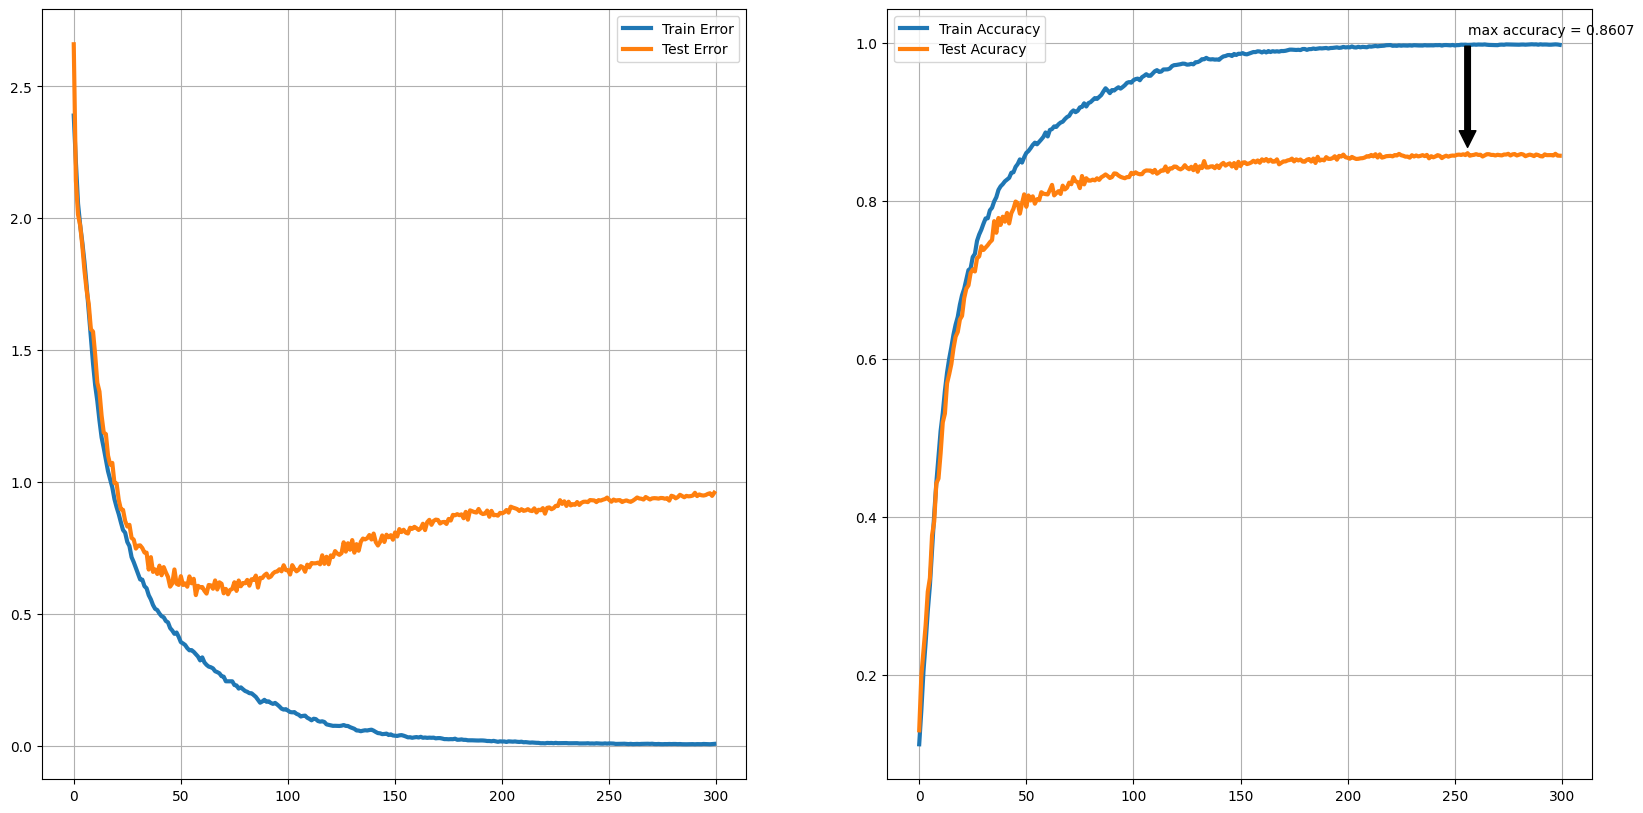

In [11]:
f, (fig1, fig2) = plt.subplots(1, 2, figsize=(20, 10))
n = len(train_loss)
fig1.plot(range(n), train_loss, '-', linewidth='3', label='Train Error')
fig1.plot(range(n), test_loss, '-', linewidth='3', label='Test Error')
fig2.plot(range(n), train_accuracy, '-', linewidth='3', label='Train Accuracy')
fig2.plot(range(n), test_accuracy, '-', linewidth='3', label='Test Acuracy')
fig2.annotate('max accuracy = %s'%(ymax), xy=(xmax, ymax), xytext=(xmax, ymax+0.15), arrowprops=dict(facecolor='black', shrink=0.05))
fig1.grid(True)
fig2.grid(True)
fig1.legend()
fig2.legend()
f.savefig("./trainTestCurve.png")

In [12]:
torch.save(model.state_dict(), '/content/model1.pt')